In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

In [7]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)
    
texts, target = text_helpers.load_movie_data()

In [8]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # 単語埋め込みのサイズ
doc_embedding_size = 100   # 文書埋め込みのサイズ
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # 不正解サンプルの数
window_size = 3       # 左側の単語の数

# トレーニングにチェックポイントを追加
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

# テストワードを設定
stops = []

# テストワードを選択
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [9]:
# テキストを正規化
texts = text_helpers.normalize_text(texts, stops)

# テキストの長さは少なくともウィンドウのサイズと同じでなければならない
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]
assert(len(target)==len(texts))

In [11]:
# データセットとディクショナリを作成
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# テストワードのキーを取得
valid_examples = [word_dictionary[x] for x in valid_words]

In [12]:
# 単語埋め込みと文書埋め込みを定義
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

# NCE損失関数のパラメータ
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [13]:
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [14]:
# ウィンドウ内の単語埋め込みを足し合わせる
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

# 単語埋め込みの末尾に文書埋め込みを連結
final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])

In [15]:
# 予測値をもとに損失値を取得
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=final_embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
                                     
# 最適化関数を作成
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

In [16]:
# テストワードに対するコサイン類似度
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [17]:
# モデル保存関数を作成
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

# 変数を初期化
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # トレーニングステップを実行
    sess.run(train_step, feed_dict=feed_dict)

    # 損失値を取得
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # 検証：テストワードと最も関連する上位5つの単語を出力
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # 最も近くにある単語の数
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # ディクショナリと埋め込みを保存
    if (i+1) % save_embeddings_every == 0:
        # 単語ディクショナリを保存
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # 埋め込みを保存
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Loss at step 100 : 595.5919799804688
Loss at step 200 : 580.5769653320312
Loss at step 300 : 595.9642944335938
Loss at step 400 : 552.0300903320312
Loss at step 500 : 598.5682373046875
Loss at step 600 : 542.4413452148438
Loss at step 700 : 535.6239013671875
Loss at step 800 : 515.5660400390625
Loss at step 900 : 534.2012329101562
Loss at step 1000 : 489.6730651855469
Loss at step 1100 : 467.9903564453125
Loss at step 1200 : 459.339111328125
Loss at step 1300 : 452.9353332519531
Loss at step 1400 : 409.00439453125
Loss at step 1500 : 428.1279296875
Loss at step 1600 : 376.125244140625
Loss at step 1700 : 423.7170715332031
Loss at step 1800 : 394.2635498046875
Loss at step 1900 : 346.75555419921875
Loss at step 2000 : 353.8563232421875
Loss at step 2100 : 356.78173828125
Loss at step 2200 : 309.2934265136719
Loss at step 2300 : 332.9071044921875
Loss at step 2400 : 314.1038513183594
Loss at step 2500 : 322.1781311035156
Loss at step 2600 : 311.42681884765625
Loss at step 2700 : 286.2791

Loss at step 17800 : 60.17247772216797
Loss at step 17900 : 61.044212341308594
Loss at step 18000 : 63.475521087646484
Loss at step 18100 : 59.323524475097656
Loss at step 18200 : 62.80095291137695
Loss at step 18300 : 52.79734420776367
Loss at step 18400 : 57.28860855102539
Loss at step 18500 : 55.01333999633789
Loss at step 18600 : 54.143150329589844
Loss at step 18700 : 58.17826843261719
Loss at step 18800 : 45.62007522583008
Loss at step 18900 : 50.36151123046875
Loss at step 19000 : 62.27119445800781
Loss at step 19100 : 52.7069206237793
Loss at step 19200 : 50.7365837097168
Loss at step 19300 : 54.131046295166016
Loss at step 19400 : 43.745567321777344
Loss at step 19500 : 42.349464416503906
Loss at step 19600 : 58.77524185180664
Loss at step 19700 : 48.19748306274414
Loss at step 19800 : 54.545413970947266
Loss at step 19900 : 48.47010040283203
Loss at step 20000 : 55.50240707397461
Nearest to love: performances, rooting, specimen, craven, happened,
Nearest to hate: mystery, com

Loss at step 35100 : 30.642078399658203
Loss at step 35200 : 32.171897888183594
Loss at step 35300 : 40.973270416259766
Loss at step 35400 : 36.98944854736328
Loss at step 35500 : 39.140113830566406
Loss at step 35600 : 40.06830596923828
Loss at step 35700 : 37.651309967041016
Loss at step 35800 : 31.975486755371094
Loss at step 35900 : 29.696855545043945
Loss at step 36000 : 34.002445220947266
Loss at step 36100 : 35.0015869140625
Loss at step 36200 : 31.298688888549805
Loss at step 36300 : 34.83713912963867
Loss at step 36400 : 31.285877227783203
Loss at step 36500 : 34.30521011352539
Loss at step 36600 : 21.39287567138672
Loss at step 36700 : 31.633800506591797
Loss at step 36800 : 35.13182067871094
Loss at step 36900 : 42.76901626586914
Loss at step 37000 : 33.58259201049805
Loss at step 37100 : 31.083934783935547
Loss at step 37200 : 31.958480834960938
Loss at step 37300 : 42.5211067199707
Loss at step 37400 : 33.38335418701172
Loss at step 37500 : 42.59170913696289
Loss at step 3

Loss at step 52500 : 27.97280502319336
Loss at step 52600 : 19.635046005249023
Loss at step 52700 : 34.366600036621094
Loss at step 52800 : 30.73814582824707
Loss at step 52900 : 37.41647720336914
Loss at step 53000 : 25.520389556884766
Loss at step 53100 : 27.275554656982422
Loss at step 53200 : 20.44304084777832
Loss at step 53300 : 31.145723342895508
Loss at step 53400 : 28.887409210205078
Loss at step 53500 : 33.14796829223633
Loss at step 53600 : 32.51393508911133
Loss at step 53700 : 28.077856063842773
Loss at step 53800 : 29.132970809936523
Loss at step 53900 : 23.454805374145508
Loss at step 54000 : 28.446121215820312
Loss at step 54100 : 27.738672256469727
Loss at step 54200 : 31.85224151611328
Loss at step 54300 : 30.307661056518555
Loss at step 54400 : 25.212141036987305
Loss at step 54500 : 21.027870178222656
Loss at step 54600 : 34.96223831176758
Loss at step 54700 : 17.756149291992188
Loss at step 54800 : 22.086610794067383
Loss at step 54900 : 21.296268463134766
Loss at 

Loss at step 69900 : 17.770709991455078
Loss at step 70000 : 24.445777893066406
Nearest to love: but, performances, as, if, are,
Nearest to hate: mystery, plausibility, red, comedian, tried,
Nearest to happy: surroundings, pervasive, goodhearted, frighten, cannot,
Nearest to sad: predictable, progress, element, solely, flailing,
Nearest to man: coincidences, are, force, with, down,
Nearest to woman: jacquots, boldly, everybody, jacquot, rollerball,
Model saved in file: /notebooks/temp/doc2vec_movie_embeddings.ckpt
Loss at step 70100 : 27.048879623413086
Loss at step 70200 : 21.89936065673828
Loss at step 70300 : 29.347429275512695
Loss at step 70400 : 20.14341926574707
Loss at step 70500 : 22.103862762451172
Loss at step 70600 : 18.734174728393555
Loss at step 70700 : 20.314733505249023
Loss at step 70800 : 20.14524269104004
Loss at step 70900 : 25.01312255859375
Loss at step 71000 : 18.64306640625
Loss at step 71100 : 17.293113708496094
Loss at step 71200 : 30.693174362182617
Loss at 

Loss at step 86200 : 16.667465209960938
Loss at step 86300 : 21.153053283691406
Loss at step 86400 : 28.433826446533203
Loss at step 86500 : 18.996074676513672
Loss at step 86600 : 21.81645965576172
Loss at step 86700 : 18.747936248779297
Loss at step 86800 : 13.719922065734863
Loss at step 86900 : 19.02384376525879
Loss at step 87000 : 19.6602725982666
Loss at step 87100 : 17.850257873535156
Loss at step 87200 : 23.04460334777832
Loss at step 87300 : 22.39332389831543
Loss at step 87400 : 22.187095642089844
Loss at step 87500 : 23.835601806640625
Loss at step 87600 : 19.591297149658203
Loss at step 87700 : 18.549074172973633
Loss at step 87800 : 16.922483444213867
Loss at step 87900 : 22.413406372070312
Loss at step 88000 : 22.135805130004883
Loss at step 88100 : 14.47569465637207
Loss at step 88200 : 20.02305793762207
Loss at step 88300 : 15.471404075622559
Loss at step 88400 : 18.548254013061523
Loss at step 88500 : 32.574913024902344
Loss at step 88600 : 17.617351531982422
Loss at 

In [19]:
max_words = 20             # 映画レビューの単語の最大数
logistic_batch_size = 500  # トレーニングのバッチサイズ

In [20]:
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [21]:
# テキストをインデックスのリストに変換
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# 映画レビューを特定の長さにパディングまたはトリミング
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [23]:
# ロジスティック回帰モデルのプレースホルダを定義
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# ウィンドウ内の単語埋め込みを足し合わせる
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# 埋め込みを連結する
log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

# ロジスティック回帰モデルの変数を定義
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# ロジスティック回帰モデルを設定（シグモイド関数は損失関数に含まれている）
model_output = tf.add(tf.matmul(log_final_embed, A), b)

# 損失関数を設定（交差エントロピー）
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

In [24]:
# 予測関数と正解関数を設定
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# 最適化関数を設定
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

# 変数を初期化
init = tf.global_variables_initializer()
sess.run(init)

In [25]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # テキストデータの最後に映画レビューのインデックスを追加
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # 損失値と正解率を100回おきに記録
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # テキストデータの最後に映画レビューのインデックスを追加
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 500. Train Loss (Test Loss): 6.64 (7.36). Train Acc (Test Acc): 0.55 (0.52)
Generation # 1000. Train Loss (Test Loss): 4.36 (4.87). Train Acc (Test Acc): 0.52 (0.56)
Generation # 1500. Train Loss (Test Loss): 2.94 (3.80). Train Acc (Test Acc): 0.58 (0.54)
Generation # 2000. Train Loss (Test Loss): 2.32 (2.51). Train Acc (Test Acc): 0.58 (0.59)
Generation # 2500. Train Loss (Test Loss): 2.55 (2.48). Train Acc (Test Acc): 0.57 (0.57)
Generation # 3000. Train Loss (Test Loss): 2.50 (2.64). Train Acc (Test Acc): 0.58 (0.52)
Generation # 3500. Train Loss (Test Loss): 2.55 (3.02). Train Acc (Test Acc): 0.58 (0.48)
Generation # 4000. Train Loss (Test Loss): 2.58 (3.12). Train Acc (Test Acc): 0.55 (0.49)
Generation # 4500. Train Loss (Test Loss): 3.08 (3.09). Train Acc (Test Acc): 0.58 (0.51)
Generation # 5000. Train Loss (Test Loss): 2.40 (2.64). Train Acc (Test Acc): 0.56 (0.50)
Generation # 5500. Train Loss (Test Loss): 2.51 (2.42). Train Acc (Test Acc): 0.51 (0.56)
Generation 

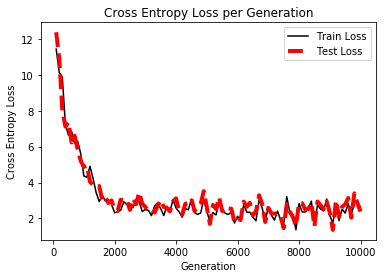

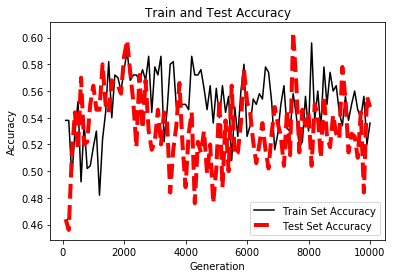

In [26]:
# 損失値をプロット
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# トレーニングセットとテストセットの正解率をプロット
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()